In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import ipywidgets as widgets
%matplotlib widget

In [12]:
# Fit a 2 dimensional polynom of order n, like:
# z = a + b*x + c*y + d*x*y (1st order)
# or
# z = a + b*x + c*x^2 + d*y + e*x*y + f*x^2*y + g*y^2 + h*x*y^2 + i*x^2*y^2 (2nd order)
# etc.
class PolynomialModel:
    def __init__(self, x, y, z, order=2):
        self.order = order
        G = self.poly_matrix(x, y, order)
        self.coef = np.linalg.solve(np.dot(G.T, G), np.dot(G.T, z))

    def poly_matrix(self, x, y, order):
        nbcols = (order + 1) ** 2
        G = np.zeros((x.size, nbcols))
        ij = itertools.product(range(order + 1), range(order + 1))
        for k, (i, j) in enumerate(ij):
            G[:, k] = x ** i * y ** j
        return G

    def estimate(self, x, y):
        xy = self.poly_matrix(x, y, self.order)
        return xy.dot(self.coef)

In [13]:
# Fit a plane
class PlaneModel():
    def __init__(self,datax,datay,dataz):
        self.x = datax
        self.y = datay
        self.v = dataz
        xy = np.array([datax, datay, np.ones(datax.shape)]).T
        self.coef = np.linalg.solve(np.dot(xy.T, xy), np.dot(xy.T, dataz))

    def estimate(self,x,y):
        xy = np.array([x,y,1])
        return xy.dot(self.coef)

In [14]:
def ParseLog(logs):
    X = []
    Y = []
    Z = []
    for line in logs.split("\n"):
        success, x, y, z = ParseLine(line)
        if success:
            X.append(x)
            Y.append(y)
            Z.append(z)
    return X, Y, Z

In [15]:
def ParseLine(line):
    l = line.split("[")
    if len(l) >= 5:
        x = [float(x.strip()) for x in l[2].split("]")[0].split(",")]
        y = [float(x.strip()) for x in l[3].split("]")[0].split(",")]
        z = [float(x.strip()) for x in l[4].split("]")[0].split(",")]
        return True, x, y, z
    return False, None, None, None

In [18]:
logs = """
2020.11.05 18:51:20,891 [DEBUG] - AutoFocus: Success - x = [9, 7.125, 7.125, 9.0002, 10.8752, 12.7502, 12.75, 12.75, 10.8748, 8.9998, 7.1248, 5.2498, 5.25, 5.25, 7.1252, 9.0002, 10.8752, 12.7502] - y = [11, 10.9998, 9.1248, 9.125, 9.125, 9.125, 12.8752, 14.7502, 14.75, 14.75, 14.75, 14.75, 9.1248, 7.2498, 7.25, 7.25, 7.25, 7.25] - z = [7.04005, 7.04755, 7.04515, 7.03755, 7.0275, 7.01675, 7.0248, 7.02595, 7.0353, 7.0417, 7.04885, 7.0528, 7.05075, 7.0456, 7.03955, 7.03205, 7.02325, 7.0127] - AutoFocusMap, sharpness level: 5.0462
2020.11.05 19:06:46,606 [DEBUG] - AutoFocus: Success - x = [9, 7.125, 7.125, 9.0002, 10.8752, 12.7502, 12.75, 12.75, 10.8748, 8.9998, 7.125, 5.2498, 5.25, 5.25, 7.1252, 9.0002, 10.8755, 12.7502] - y = [11, 10.9998, 9.1248, 9.125, 9.125, 9.125, 12.8752, 14.7502, 14.75, 14.75, 14.75, 14.75, 9.1248, 7.2498, 7.25, 7.25, 7.25, 7.25] - z = [7.0407, 7.04785, 7.04535, 7.03755, 7.0273, 7.0172, 7.02495, 7.02605, 7.035, 7.042, 7.0486, 7.05265, 7.05055, 7.0456, 7.03895, 7.03175, 7.0226, 7.0122] - AutoFocusMap, sharpness level: 5.0462
"""

<IPython.core.display.Javascript object>


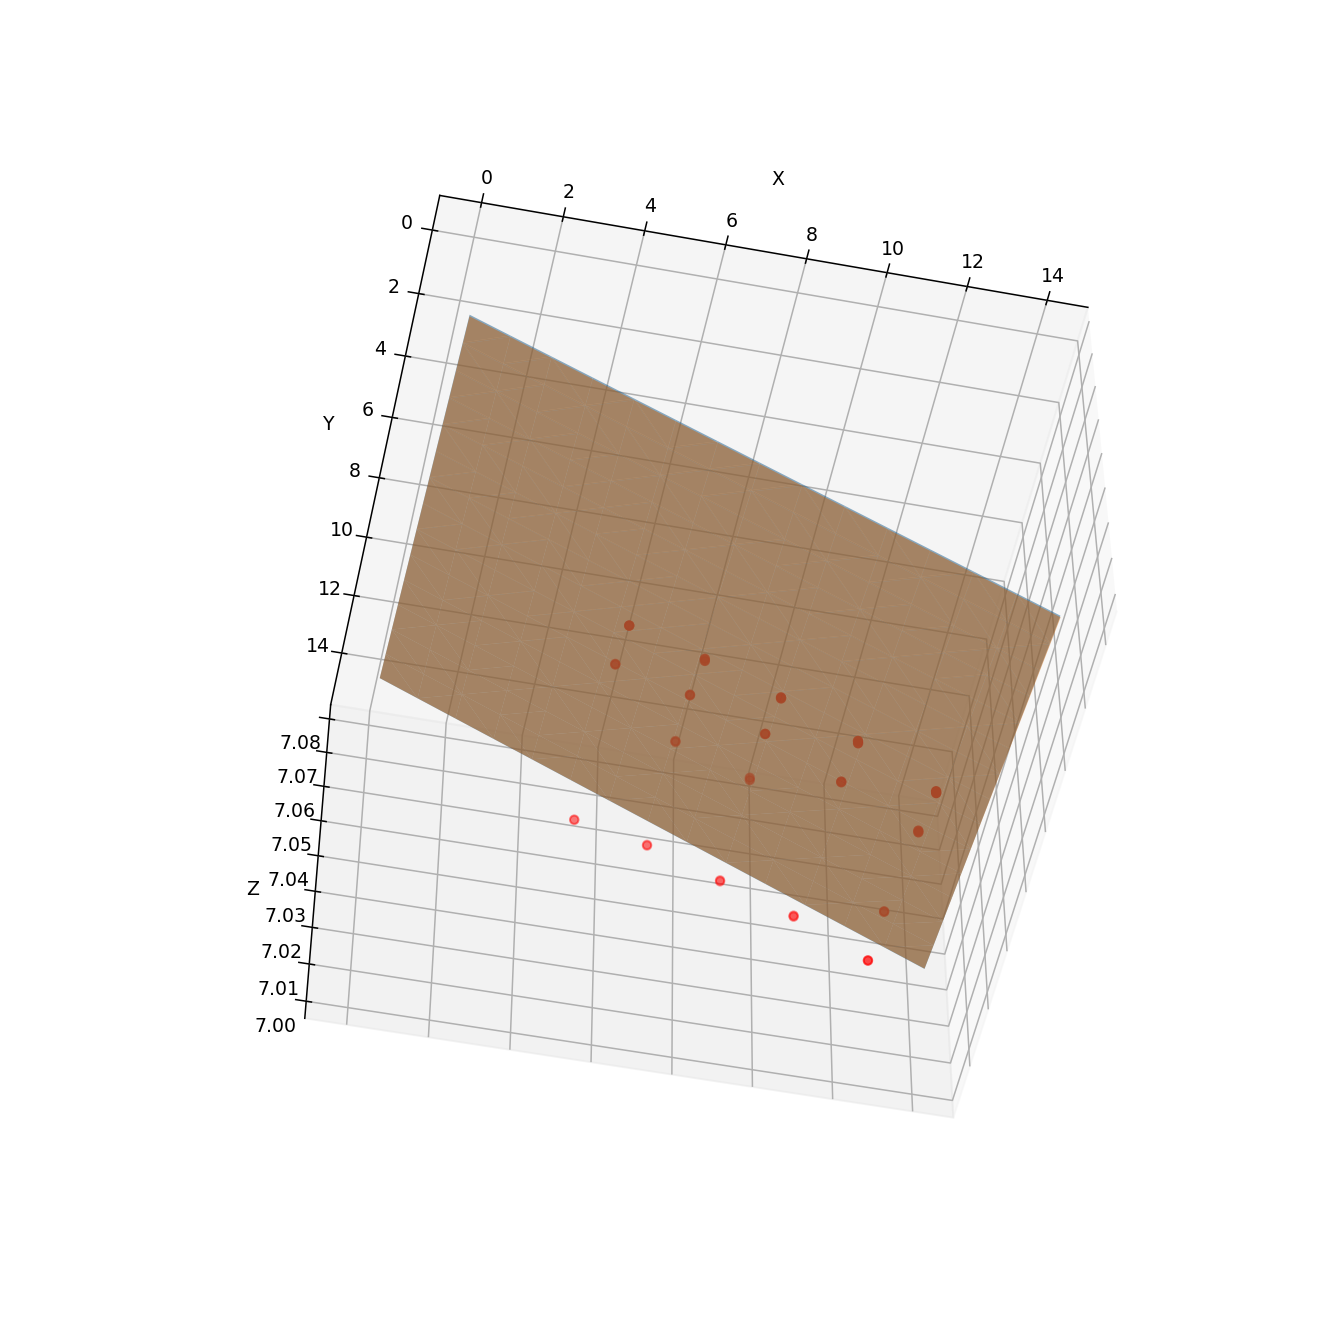

In [28]:
labels = []

polynom_order = 0
margin = 0.1

x, y, z = ParseLog(logs)
plt.close('all')
for i in range(len(x)):
    if i % 2 == 0:
        fig = plt.figure(figsize=(9.8,9.8))
        ax = fig.add_subplot(111, projection='3d')
    datax, datay, dataz = np.asarray(x[i]), np.asarray(y[i]), np.asarray(z[i])
    poly_model = PolynomialModel(datax, datay, dataz, polynom_order)
    plane_model = PlaneModel(datax, datay, dataz)

    # create a wiremesh for the plane that the predicted values will lie
    xx, yy, zz = np.meshgrid(np.arange(0, 15, 1), np.arange(0, 15, 1), np.ones(datax.shape))
    poly_surf = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
    plane_surf = poly_surf.copy()
    for j in range(len(poly_surf)):
        poly_surf[j, 2] = poly_model.estimate(poly_surf[j, 0], poly_surf[j, 1])
        plane_surf[j, 2] = plane_model.estimate(plane_surf[j, 0], plane_surf[j, 1])

    # plot the original data, predicted data, and wiremesh plane
    ax.scatter(datax, datay, dataz, color='r')
    if polynom_order > 0:
        surf = poly_surf
    else:
        surf = plane_surf
    if i < len(labels):
        label = labels[i]
    else:
        label = None
    surf = ax.plot_trisurf(surf[:, 0], surf[:, 1], surf[:, 2], alpha=0.5, label=label)
    #surf._facecolors2d = surf._facecolors3d
    #surf._edgecolors2d = surf._edgecolors3d

    mean_z = np.around(np.mean(np.array(z[1])), 2)
    # ax.set_zlim(mean_z - margin / 2, mean_z + margin / 2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # ax.legend()
    #plt.show()